In [2]:
from DataCollector import importNotDetectData
# Retrieve data from originData
import platform
data = importNotDetectData(2101,2201)
print(platform.platform())
print('Total size of data is... %d' % len(data))

c:\users\shion\pycharmprojects\projectroute112021\venv\lib\site-packages\elasticsearch\connection\base.py:200: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.16/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)


Windows-10-10.0.22000-SP0
Total size of data is... 17701


<hr>

# destIPでの分類
ハニーポットの総数は22個であることがわかった。

not detectアクセスデータに関しては

In [3]:
# ここでは、destination_ipでデータを分類している。
from DataGrouper import groupByDestIp

# ipアドレスで仕分ける
geoIps = groupByDestIp(data)
# とりあえず結果を見てみたい
print('Total Num of Variation in GeoIp: %d' % len(geoIps))
print('IP'.center(15), "total")
for ip, hit in geoIps.items():
    print(str(ip).rjust(15), str(len(hit)).rjust(5))

Total Num of Variation in GeoIp: 22
       IP       total
   13.49.30.108  2189
 18.229.242.225  3024
 165.22.204.232  2212
  3.126.200.153  4615
   139.59.35.98  2076
    3.6.183.235  3254
  45.32.119.106  1791
  44.227.53.230  2155
 52.213.219.192  2580
 13.113.114.211  2406
 13.209.159.235  2433
 18.162.103.211  2267
  199.247.11.85  2028
    45.32.28.50  1697
104.238.185.103  2070
 157.245.204.40  1702
 15.185.134.185  2079
155.138.134.102  1757
   52.74.78.244  1478
  13.211.95.147  1928
  133.34.169.17  1506
   103.81.85.89    74


# Signature ベースでの分類
Signatureごとに仕分けた上で、

受信IPにおいて同一IPからのアクセスがあるか確認したい
(受信IPはdestination_ip)
## 結果
合計22のハニーポットが存在する中で、2つ以上で同じシグネチャーのアクセスが観測できれば、「流行している攻撃」と解釈することが可能であるが、

非常に多くのnot detectedについて流行していることが確認された

→既知のものが多く含まれている可能性が高い

In [4]:
from DataGrouper import groupBySignature
#ここでは、同じsignature内に同一のipからのアクセスがどれくらいあるか確認する。
dataS = groupBySignature(data)
# result1はsignatureごとに分類した上に同一destination_ipについて整理したもの
result1 = {}
for s, hits in dataS.items():
    #それぞれのIPについて分類する。
    resultIps = {}
    for hit in hits:
        if not hit['_source']['destination_ip'] in resultIps:
            resultIps[hit['_source']['destination_ip']] = []
        resultIps[hit['_source']['destination_ip']].append(hit)
    # Signature s についての分類が完了
    # データとして格納
    result1[s] = resultIps
# result1を並び変える。
# len(x[1])refers to the size of the variation of destination_ip
# ↑ if this value is bigger than 1, it means that it is prevalent
result1 = sorted(result1.items(), key=lambda x: len(dataS[x[0]]), reverse=True)
result1 = sorted(result1, key=lambda x: len(x[1]), reverse=True)
# Print and Export result1 as "signatures_by_num_destIP(1-10).csv"
f = open("resultData/signatures_by_num_destIP(1-10).csv", "wb")
# 書き出す項目について整理しておく
print("signature".center(50), "Spots", "Counts")
f.write('Signature,Spots,Hits\n'.encode('utf-8'))
for s, r in result1:
    print(s[:50].ljust(50), str(len(r)).rjust(5), str(len(dataS[s])).rjust(6))
    b = (s + ',' + str(len(r)) + ',' + str(len(dataS[s])) + '\n').encode('utf-8')
    f.write(b)
f.flush()
f.close()

                    signature                      Spots Counts
/v1.24/containers/create                              22   7077
/goform/setUsbUnload/.js                              22   1116
/backupmgt/localJob.php                               22    281
/v1.40/containers/create                              22    216
/RPC2                                                 21  31026
/                                                     21    232
/_config/query_servers/cmd                            21     79
/body.txt                                             21     27
/ws/v1/cluster/apps                                   20     98
/include/makecvs.php                                  20     92
/tools.cgi                                            20     41
/checkValid                                           19    590
/console/css/%252e%252e/consolejndi.portal            19     42
/cgi-bin/masterCGI                                    19     33
/cgibin/mainfunction.cgi&action=login&ke

# データの整合性
データの整合性について気になったので以下で確認してみた。

not detectではポットからポット自身に送っているものはないというが、どこかで確認した気がする。
## 結論

not detectラベルがついたデータの中では、
- source_ipとgeoip>ipは完全に一致
- destination_ipとsource_ipが同じであるものは見つからなかった←(おそらくElasticSearchをいじっている中で同じものに出くわした覚えがあるのでこれについては追加で調査したい)

In [ ]:
from DataOutputter import *
import importlib

result2 = []
result3 = []
for d in data:
    if 'ip' in d['_source']['geoip']:
        if not str(d['_source']['source_ip']) == str(d['_source']['geoip']['ip']):
            result2.append(d)
        if str(d['_source']['destination_ip']) == str(d['_source']['geoip']['ip']):
            result2.append(d)
    else:
        result3.append(d)
print(len(result2))
print(len(result3))
easyOutput(data=result3, folder='Unknown')

# グラフ化
以下のコードでは、7日ごとに全データを集計した。

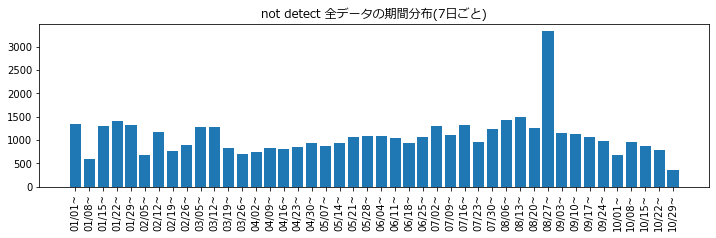

In [7]:
from Grapher import *
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [12, 3]
starting = pd.to_datetime("2021/1/1 00:00:00")
ending = pd.to_datetime("2021/11/1 00:00:00")
visualizeTimeData(data, starting=starting.timestamp(), ending=ending.timestamp(), title='not detect 全データの期間分布(7日ごと)',
                  loc="not detect 全データの期間分布")

8.27から9.2までのデータが気になる...

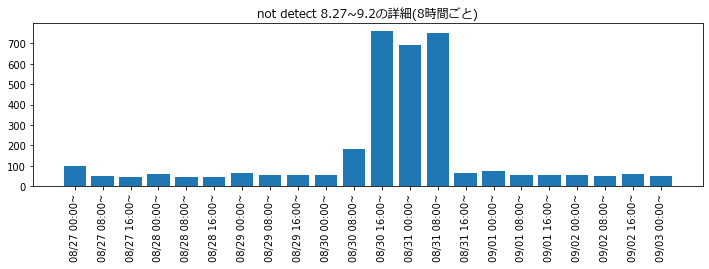

In [8]:
starting = pd.to_datetime("2021/8/27 00:00:00")
ending = pd.to_datetime("2021/9/3 00:00:00")
visualizeTimeData(data, starting=starting.timestamp(), ending=ending.timestamp(), title='not detect 8.27~9.2の詳細(8時間ごと)',
                  loc='8.27~9.2の調査',
                  period=8 * 60 * 60, x_axis='hour')

もう少し絞って見てみる

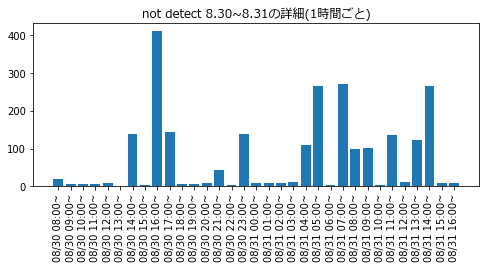

In [6]:
from Grapher import *
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [8, 3]
starting = pd.to_datetime("2021/8/30 8:00:00")
ending = pd.to_datetime("2021/8/31 16:00:00")
visualizeTimeData(records=data, starting=starting.timestamp(), ending=ending.timestamp(),
                  title='not detect 8.30~8.31の詳細(1時間ごと)', loc='8.27~9.2の調査',
                  period=1 * 60 * 60, x_axis='hour')

以下のコードではシグネチャーごとのデータの可視化を行っている。

In [9]:
from Grapher import *

plt.rcParams["figure.figsize"] = [12, 3]
starting = pd.to_datetime("2021/1/1 00:00:00")
ending = pd.to_datetime("2021/11/1 00:00:00")
i = 0
for s, d in dataS.items():
    i = i + 1
    visualizeTimeData(d, starting=starting.timestamp(), ending=ending.timestamp(), title=str(s) + 'の期間分布',
                      loc='Signatureごとの期間分布')
    plt.close()
    print('%d / %d has Completed...' % (i, len(dataS.items())))

1 / 157 has Completed...
2 / 157 has Completed...
3 / 157 has Completed...
4 / 157 has Completed...
5 / 157 has Completed...
6 / 157 has Completed...
7 / 157 has Completed...
8 / 157 has Completed...
9 / 157 has Completed...
10 / 157 has Completed...
11 / 157 has Completed...
12 / 157 has Completed...
13 / 157 has Completed...
14 / 157 has Completed...
15 / 157 has Completed...
16 / 157 has Completed...
17 / 157 has Completed...
18 / 157 has Completed...
19 / 157 has Completed...
20 / 157 has Completed...
21 / 157 has Completed...
22 / 157 has Completed...
23 / 157 has Completed...
24 / 157 has Completed...
25 / 157 has Completed...
26 / 157 has Completed...
27 / 157 has Completed...
28 / 157 has Completed...
29 / 157 has Completed...
30 / 157 has Completed...
31 / 157 has Completed...
32 / 157 has Completed...
33 / 157 has Completed...
34 / 157 has Completed...
35 / 157 has Completed...
36 / 157 has Completed...
37 / 157 has Completed...
38 / 157 has Completed...
39 / 157 has Complete

↓パスごとの統計結果

[31026, 7077, 1116, 788, 629, 603, 590, 281, 232, 216, 168, 162, 154, 150, 148, 146, 144, 143, 143, 141, 140, 139, 138, 137, 136, 133, 130, 130, 118, 118, 114, 105, 98, 92, 79, 67, 65, 64, 43, 42, 42, 42, 41, 40, 37, 34, 33, 32, 29, 29, 28, 28, 27, 26, 26, 24, 24, 23, 22, 22, 22, 20, 19, 19, 19, 17, 17, 16, 16, 15, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 13, 13, 12, 11, 8, 8, 7, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


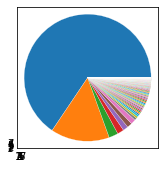

In [10]:
counts=[]
for s,d in dataS.items():
    counts.append(len(d))
counts=sorted(counts,reverse=True)
print(counts)
signatureRoundGraph(keys=None,data=counts)


In [ ]:
for d in dataS['/RPC2'][:20]:
    print(d['_id'])